# WIP
## IES - Python - Project
### Marathon Results
### Data analysis
#### David Koubek, Jiri Zelenka

### Content
#### Import Required Packages
#### Data Loading + Merging
#### Technical Improvements:
##### - Renaming Columns + Adding Gender
##### - Cleaning Time + Adding Minutes
##### - Cleaning Names of Runners
-------------------------------------
#### Unique Countries, Names and Ages
#### Runners who Repeated Marathon
#### Percentage of Czechs Over Time
-------------------------------------
#### Pivot tables - Year x Gender
###### Min rank
###### Min time
###### Mean time
-------------------------------------
#### Medals
-------------------------------------
#### M/W Histograms over years

### Import required packages.

In [4]:
import pandas as pd # for dataframe
import numpy as np  # working with arrays
import matplotlib.pyplot as plt  # Basic plots
import seaborn as sns   # Plots, boxplots

from collections import Counter

### Data loading + Merging

#### 1995 - 2019 (excluding 2012)

In [5]:
years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, # 2012 is missing !!!, 24 runs
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

df_all = []

for i in years:
    df = pd.read_csv('../Scraper/Data_Marathons_Prague/data_' + str(i) + '.csv')
    df["Year"] = i
    df_all.append(df)
    
#  this creates a list of dfs, possible to get inside with indexes [1]...


df_merged = pd.concat(df_all, ignore_index=True)   # Important for obtaining overall index

len(df_merged)

94299

In [6]:
df_merged.head()
# df_merged.tail()

,Rank,Name,Chip time,St. number,Nationality,Age cat.,Year
0,1,Turbo Tummo,2:12:44,3,-,-,1995
1,2,Andrzej Krzyscin,2:16:53,8,-,-,1995
2,3,Pavel Klimes,2:16:56,7,-,-,1995
3,4,Miriusz Kaminski,2:17:06,28,-,-,1995
4,5,Jackson Kipngok,2:17:13,1,-,-,1995


### Technical Improvements

#### Renaming Columns + Adding Gender
#### Cleaning Time + Adding Minutes
#### Cleaning Names of Runners

In [7]:

### Renaming Columns

df_renamed = df_merged.rename(columns={"Age cat.":"Age", "Chip time":"Time","St. number":"Start_number"  })

## Adding Gender column  

df_renamed["Gender"] = df_renamed["Age"].astype(str).str[0]

# df_renamed.head()
df_renamed.tail()

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender
94294,7296,Jaroslav Sopuch,6:45:30,4652,SVK,M65,2019,M
94295,7297,Dong Tran,6:39:37,7542,VNM,MAM,2019,M
94296,7298,Jiří Přidal,6:57:39,6743,CZE,M65,2019,M
94297,7299,Iva Valentová,6:42:54,F2060,CZE,W45,2019,W
94298,7300,EHUD AVNI,6:59:04,7331,ISR,M50,2019,M


In [8]:

### Time Cleaning

    # Deleting 288 observations with time = "-" - mostly from year 1998, reason of this = ???
df_times = df_renamed[df_renamed.Time != "-"]

df_times.reset_index(drop = True,inplace=True)

    # Check for non-"-" times
times = df_times["Time"]
times.describe()

len(df_times)

# Keep working with 94 011 Runners = df_times


94011

In [9]:

### Counting minutes from Total time

tot_min = []
times = list(times)

for i in times:
    t=i.split(':')
    tot_min.append(int(t[0])*60+int(t[1])*1 +int(t[2])/60)
    
# len(tot_min)
tot_min = pd.DataFrame(tot_min)

df_mins = pd.concat([df_times, tot_min], axis=1)
df_mins = df_mins.rename(columns={0:"tot_mins"})


In [10]:
    # List of roudned minutes

Mins = list(np.around(np.array(tot_min),0))
Mins = pd.DataFrame(Mins)

df_mins = pd.concat([df_mins, Mins], axis=1)
df_mins = df_mins.rename(columns={0:"Mins"})

df_mins.head()
# df_mins.tail()

# Keep working with Dataframe including rounded minutes = df_mins


,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins
0,1,Turbo Tummo,2:12:44,3,-,-,1995,-,132.733333,133.0
1,2,Andrzej Krzyscin,2:16:53,8,-,-,1995,-,136.883333,137.0
2,3,Pavel Klimes,2:16:56,7,-,-,1995,-,136.933333,137.0
3,4,Miriusz Kaminski,2:17:06,28,-,-,1995,-,137.100000,137.0
4,5,Jackson Kipngok,2:17:13,1,-,-,1995,-,137.216667,137.0


In [11]:

###  Cleaning Names:

all_names = list(df_mins.Name)

#print(sorted(all_names))

print(sorted(all_names)[0:500])
print(sorted(all_names)[len(all_names)-500:len(all_names)])

    # In the head we can see some names starting with spaces or dots - we will transform them.
    # In the tail there are names of Russian, Israeili, Chiense or Japanese Runners.
    # There are not so many of them, we keep them in original form


[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' Peter Puškár                   ', ' Radek Podracký               ', ' STEINIVAR', ',Jiří Stránský Judr.', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '- -', '-

In [12]:
indd = df_mins.index[df_mins['Name'] == ' Peter Puškár                   '].tolist()
df_mins.loc[indd,'Name'] = "Peter Puškár"
indd = df_mins.index[df_mins['Name'] == ' Radek Podracký               '].tolist()
df_mins.loc[indd,'Name'] = "Radek Podracký"
indd = df_mins.index[df_mins['Name'] == ' STEINIVAR'].tolist()
df_mins.loc[indd,'Name'] = "STEINIVAR"
indd = df_mins.index[df_mins['Name'] == ',Jiří Stránský Judr.'].tolist()
df_mins.loc[indd,'Name'] = "Jiří Stránský Judr."
indd = df_mins.index[df_mins['Name'] == '.Jiří Nekuža'].tolist()
df_mins.loc[indd,'Name'] = "Jiří Nekuža"
indd = df_mins.index[df_mins['Name'] == '- 50008873'].tolist()
df_mins.loc[indd,'Name'] = "- -"
indd = df_mins.index[df_mins['Name'] == '- 50044654'].tolist()
df_mins.loc[indd,'Name'] = "- -"
indd = df_mins.index[df_mins['Name'] == '?IVIND JOHANSEN'].tolist()
df_mins.loc[indd,'Name'] = "IVIND JOHANSEN"
indd = df_mins.index[df_mins['Name'] == '\u202aesty rosenberg\u202c\u200f'].tolist()
df_mins.loc[indd,'Name'] = "aesty rosenberg"
indd = df_mins.index[df_mins['Name'] == '\u202aron gashri\u202c\u200f'].tolist()
df_mins.loc[indd,'Name'] = "aron gashri"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＫＯ ＫＵＳＵＮＯＫＩ'].tolist()
df_mins.loc[indd,'Name'] = "Hiroko Kusunoki"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＫＯ ＳＨＩＮＯＭＩＹＡ'].tolist()
df_mins.loc[indd,'Name'] = "Hiroko Shinomiya"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＭＩ ＹＯＮＥＺＵ'].tolist()
df_mins.loc[indd,'Name'] = "Hiromi Yonezu"
indd = df_mins.index[df_mins['Name'] == 'ＪＵＮＫＯ ＮＩＳＨＩＯＫＡ'].tolist()
df_mins.loc[indd,'Name'] = "Junko Nishioka"
indd = df_mins.index[df_mins['Name'] == 'ＫＩＳＡＫＯ ＴＯＫＯ'].tolist()
df_mins.loc[indd,'Name'] = "Kisako Toko"
indd = df_mins.index[df_mins['Name'] == 'ＫＩＹＯＫＯ ＫＡＷＡＳＡＫＩ'].tolist()
df_mins.loc[indd,'Name'] = "Kiyoko Kawasaki"
indd = df_mins.index[df_mins['Name'] == 'ＭＡＳＡＫＯ ＯＮＩＳＨＩ'].tolist()
df_mins.loc[indd,'Name'] = "Masako Onishi"
indd = df_mins.index[df_mins['Name'] == 'ＭＩＥＫＯ ＴＳＵＪＩＯＫＡ'].tolist()
df_mins.loc[indd,'Name'] = "Mieko Tsujioka"

In [13]:

# Checking the names

all_names_new = list(df_mins.Name)

#print(sorted(all_names_new)[0:500])
print(sorted(all_names_new)[len(all_names_new)-500:len(all_names_new)])

['zhang xiaokang', 'zheng huanyun', 'zheng wang', 'zhengtao zhu', 'zhichun huang', 'zhiyun song', 'zhizhong he', 'zhou li', 'zhu pei', 'zhu zheng', 'zihou sun', 'zihou sun', 'zihou sun', 'zion cohen zion cohen', 'zorana tasovac', 'zurek mirela', 'zuzana cisarova', 'zuzana kubínová', 'zuzana kubínová', 'zuzana kubínová', 'zuzana kubínová', 'zuzana kubínová', 'zuzana kubínová', 'zuzana kubínová', 'zuzana rakušanová', 'zuzana rakušanová', 'zuzana rakušanová', 'zuzana rakušanová', 'zuzana rakušanová', 'zuzana rakušanová', 'zuzana rakušanová', '\xa0ANDREA MANELLINI', '\xa0ARCANGELO PASSIRANI', '\xa0CARMINE TORRICELLA', '\xa0CLAUDIO CLARETTO', '\xa0DAMIEN FIORANI', '\xa0FRANCESCO BOSCO', '\xa0GENNARO MINERVA', '\xa0GIANROCCO REALE', '\xa0GIOVANNI BAGNOLI', '\xa0GIUSEPPE MATTEUCCI', '\xa0MARCO CIMINI', '\xa0MASSIMO PICCA', '\xa0MAURIZIO FACCIONI', '\xa0ROBERTO BISCO', '\xa0RUBEN CASTELLETTI', '\xa0SOCCORSO CRESTA', 'ÁDÁM BALOG', 'ÁDÁM BERKES', 'ÁGNES HORNUNG', 'ÁLVARO PARIENTE', 'ÁRPÁD KOCSIS

In [14]:
df_mins['Name'] = [str(i).lower() for i in df_mins['Name']] 
   # Changing all to lowercase
    
df_final = df_mins

In [15]:
# Doplnění Ranků ... #############tRANSLATE PLS#############

missing_ranks = list(range(1601,1640))
missing_ranks = list(map(str, missing_ranks))

len(missing_ranks)
len(df_final.loc[df_final['Rank']=="-","Rank"])
# Check of the length of source and target = OK

df_final.loc[df_final['Rank']=="-","Rank"] = missing_ranks

df_final[df_final["Year"]==1997].tail(40)
    # Check of the new Ranks

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins
3285,1600,barbora dohnalová,5:10:36,393,TCH,WAM,1997,W,310.600000,311.0
3286,1601,jan prosecký,5:10:43,3857,TCH,MAM,1997,M,310.716667,311.0
3287,1602,véronique bruneau,5:12:46,336,FRA,WAM,1997,W,312.766667,313.0
3288,1603,jiří mareš,5:12:57,3760,TCH,MAM,1997,M,312.950000,313.0
3289,1604,miloslav kníže,5:12:58,3639,TCH,MAM,1997,M,312.966667,313.0
3290,1605,ladislav hnízdil,5:14:31,2975,TCH,M60,1997,M,314.516667,315.0
3291,1606,melissa stark,5:16:11,319,GBR,WAM,1997,W,316.183333,316.0
3292,1607,eduard bartek,5:16:12,3511,TCH,MAM,1997,M,316.200000,316.0
3293,1608,josef kocourek,5:16:17,3652,TCH,MAM,1997,M,316.283333,316.0
3294,1609,miroslav hofman,5:16:33,3859,TCH,M40,1997,M,316.550000,317.0


In [16]:
# All Ranks change into Integers   

df_final["Rank"] = pd.to_numeric(df_final["Rank"])

### Unique Countries, Names and Ages

In [17]:
#All unique countries:

uq_countries = df_final.Nationality.unique()   
len(uq_countries)

# uq_countries

205

In [18]:
# All unique ages:

uq_ages = df_final.Age.unique()
len(uq_ages)

# uq_ages

15

In [19]:
# All unique names:

uq_names = df_final.Name.unique()
len(uq_names)

# uq_names

66087

### Runners who Repeated Marathon

In [20]:

############################################################################################x

# Count how many names are in multiple runs (not in the same run) and in how many:

all_names = list(df_final.Name)
num_of_runs = Counter(all_names)

num_of_runs.most_common()
    # Number of repeating persons.
    # However, yet we cant say which of them come from the same year ("Petr Svoboda"),
    # and who repeated several Runs ("jack joseph michel brossaud")

[('- -', 179),
 ('jan bláha', 48),
 ('petr svoboda', 41),
 ('petr novák', 39),
 ('václav svoboda', 34),
 ('vladimír novák', 31),
 ('petr kubišta', 25),
 ('pavel kratina', 24),
 ('milan gatial', 24),
 ('pavel novák', 24),
 ('martin šperl', 23),
 ('petr mucha', 23),
 ('josef kostka', 23),
 ('vladimír klail', 23),
 ('ivo kostiha', 23),
 ('radim kotlaba', 23),
 ('josef svoboda', 23),
 ('pavel novotný', 23),
 ('bohuslav plachý', 22),
 ('petr kočí', 22),
 ('miroslav pánek', 22),
 ('pavel vojta', 22),
 ('vladimír pitter', 21),
 ('václav marek', 21),
 ('július pataky', 21),
 ('petr szász', 21),
 ('peter krupka', 21),
 ('karel pudil', 21),
 ('pavel eliáš', 21),
 ('jan soviš', 20),
 ('jaroslav hrabuška', 20),
 ('tomáš ulma', 20),
 ('vladimír slavík', 20),
 ('ivan soviš', 19),
 ('petr prokeš', 19),
 ('otakar pachmann', 19),
 ('vilém sklenák', 19),
 ('luboš bílek', 19),
 ('michal burian', 19),
 ('martin chudo', 19),
 ('jan zahradník', 19),
 ('luboš racek', 19),
 ('martin licek', 19),
 ('františek 

### Percentage of Czechs Over Time

In [21]:
# Percentage of Czechs

# After inspecting each year, we noticed of the occurence of "TCH"
# instead of "CZE" in Nationality column.

# 1995 - no nationalities
# 1996 2x CZE + 0x TCH
# 1997 1x CZE + 727x TCH
# 1998 1x CZE + 1045x TCH
# 1999 986x CZE + 0x TCH
# ... CZE only


# Replacing all "TCH" with "CZE"

df_final['Nationality'] = df_final['Nationality'].replace('TCH', 'CZE')

In [22]:
years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 is missing, 1995 and 1996 is excluded, 22 runs

In [23]:
# Percents of czech Runners over years 1997-2019

cz_percent = []
for year in years:
    
    cz = len(df_final[(df_final["Nationality"] == "CZE") & (df_final["Year"] == year)])
    alls = len(df_final[df_final["Year"] == year])
    per = cz/alls
    cz_percent.append(per)
    
cz_percent

[0.4441732763880415,
 0.47074707470747074,
 0.35442127965492454,
 0.43695965417867433,
 0.43089738735327526,
 0.4439302242791029,
 0.4700230591852421,
 0.5284008156131663,
 0.39094650205761317,
 0.36576395854229354,
 0.4150470219435737,
 0.4123543755079924,
 0.408953722334004,
 0.4033751800782054,
 0.42630385487528344,
 0.5152618799861256,
 0.5562777967841259,
 0.569919945494805,
 0.5627488315734811,
 0.47634408602150535,
 0.4828776978417266,
 0.500958904109589]

In [24]:
czechs = df_final[df_final["Nationality"] == "CZE"]
len(czechs)/len(df_final)

# Overall percentage of czech Runners = 46.2 %


0.462105498292753

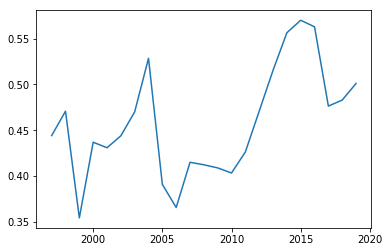

In [25]:
plt.plot(years,cz_percent)
plt.show()

################################# Graph Title

### Pivot tables 1/3

##### Gender and Years

##### -> Min + Mean rank
##### -> Min + Mean time


### 2000 - No Age Category -> No Gender available
### 1997 - Lowest Rank was "-" -> labeled above in 1st section
### 1997 + 1998 -Woman are suspiciously low Rank (1000) -> String format of Rank - solved in 1st section
### 1995 - No Age Category -> No Gender available -> Dropped this year

In [26]:
# This table shows the top ranks of M and W of the ovreall ranks in year
# Here we can see that the top woman take place about 20 of all the Runners

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Rank",aggfunc=np.min)

Year,1996,1997,1998,1999,2001,2002,2003,2004,2005,2006,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
W,44,33,37,28,25,28,18,25,13,14,...,22,24,23,15,16,17,16,17,14,15


In [27]:
# This table presents average times of W + M over years
# Non clear Genders was excluded

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.mean)


Year,1996,1997,1998,1999,2001,2002,2003,2004,2005,2006,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,226.916900,220.698705,226.805835,230.128308,233.695783,234.626645,243.901568,234.113111,247.188608,239.763168,...,249.261234,242.262222,243.752473,246.701147,241.482910,245.672165,250.024812,249.254848,249.708901,242.584982
W,241.589474,243.000000,251.589744,253.357895,259.924290,263.398671,264.205882,257.378323,269.461538,261.627957,...,274.749216,261.363412,267.196682,271.168388,267.576602,270.020333,281.958003,277.977335,278.768699,271.210976


In [28]:
# This table presents minimum times of W + M over years
# Non clear Genders was excluded

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.min)


Year,1996,1997,1998,1999,2001,2002,2003,2004,2005,2006,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,132.0,129.0,129.0,131.0,130.0,132.0,132.0,132.0,131.0,131.0,...,128.0,126.0,127.0,129.0,128.0,129.0,127.0,129.0,126.0,126.0
W,158.0,153.0,154.0,149.0,147.0,152.0,151.0,152.0,149.0,149.0,...,148.0,145.0,143.0,147.0,144.0,144.0,145.0,142.0,144.0,140.0


In [ ]:

## Let's plot Minimum and Mean times 1996-2019

df_man = df_final[df_final["Gender"] == "M"]
df_woman = df_final[df_final["Gender"] == "W"]

years = [1996,1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 is missing, 1995 is excluded because of no Genders, 23 runs


best_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    min_new_w = new_w.Mins.min()
    best_w.append(min_new_w)

best_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    min_new_m = new_m.Mins.min()
    best_m.append(min_new_m)
    
#-----------------------------------------
    
mean_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    mean_new_w = new_w.Mins.mean()
    mean_w.append(mean_new_w)

mean_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    mean_new_m = new_m.Mins.mean()
    mean_m.append(mean_new_m)
    

In [ ]:
# Average times evolution

plt.plot(years, mean_m)
plt.plot(years, mean_w)
plt.legend(['mean Man','mean Woman'], loc='upper left')
plt.show()

### Zásadní otázka, proč mám díru 2000 a naopak nemám díru 2012 ?
# Dá se to vyřešit opětovným reindexováním?

In [ ]:
# Top times evolution

plt.plot(years, best_m)
plt.plot(years, best_w)
plt.legend(['best Man','best Woman'], loc='upper right')
plt.show()

In [ ]:
sns.boxplot(x='Year', y='Mins', data=df_man)


In [ ]:
sns.boxplot(x='Year', y='Mins', data=df_woman)

In [ ]:
box_man = df_man['Mins']
box_woman = df_woman['Mins']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([box_man,box_woman], labels=['M', 'W'])

In [ ]:

sns.boxplot(x="Year", y="Mins",
            hue="Gender", palette=["m", "g"],
            data=df_genders)
sns.despine(offset=10, trim=True)

### Pivot tables 2/3

##### Nationality

##### -> Min + Mean rank
##### -> Min + Mean time


In [ ]:
df_nations = df_final[df_final["Nationality"] != "-"]
pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Rank",aggfunc=np.min)

In [ ]:

pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Mins",aggfunc=np.mean)


In [ ]:
pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Mins",aggfunc=np.min)


In [ ]:


########################################################################xx
uq_countries = uq_countries[uq_countries != "-"]
# uq_countries

national_means = []

for i in uq_countries:
        country = df_nations[df_nations["Nationality"]== i]
        country_mean = country.Mins.mean()
        national_means.append(country_mean)

print(national_means)

In [ ]:
plt.plot(national_means)
plt.show()

### Pivot tables 3/3

##### Age and Years

##### -> Min + Mean rank
##### -> Min + Mean time


In [ ]:
uq_countries

### Medals

In [ ]:
# Here we count number of Gold/Silver/Bronze Medals for each country, W/M

medals = uq_countries

counter_g = 0
counter_s = 0
coutner_b = 0

for abc in uq_countries:
    if [(df_nations["Rank"]==1) & (df_nations["Nationality"]== abc)]:
        counter_g = counter_g+1
    elif [(df_nations["Rank"]==2) & (df_nations["Nationality"]== abc)]:
        counter_s = counter_s+1
    elif [(df_nations["Rank"]==3) & (df_nations["Nationality"]== abc)]:
        counter_b = counter_b+1
    else:
    medals.append(counter_g, counter_s, counter_b)
    
    ########################################################################
    ##Nedaří se mi uložit medaile....